In [5]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import datasets as tfd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [6]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [7]:
train_data, test_data = tfd.cifar100.load_data(label_mode="coarse")
(x_train, y_train), (x_test, y_test) = train_data, test_data
x_train, x_test = np.mean(x_train, axis=3), np.mean(x_test, axis=3)

In [25]:
N_CLASSES = 20
INPUT_SIZE = (32, 32, 1)
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']
CALLBACKS = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3), tf.keras.callbacks.LearningRateScheduler(scheduler)] # Correct?
BATCH_SIZE = 32
EPOCHS = 10

In [9]:
#Set shape to (num_samples, h, w, numchannels) = (40000, 32, 32, 1)
x_train = np.expand_dims(x_train, axis=-1) 
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to one-of-K (one-hot) encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=N_CLASSES)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

TRAIN_SIZE, _ , _ , _ = x_train.shape
input_img = tf.keras.Input(shape=INPUT_SIZE)
y_pred = None

In [10]:
def task1():
    fig, axs = plt.subplots(4, 5)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.imshow(x_train[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
# task1()

In [31]:
def M4():
    global y_pred

    h0 = tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5))(input_img)
    
 
    h1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.AvgPool2D((3,3))(h1)

    h2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(h1)
    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)

    h3 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same')(h2)
    h3 = tf.keras.layers.MaxPool2D((2,2))(h3)


    fh1 = tf.keras.layers.Flatten()(h3)
    fh2 = tf.keras.layers.Dense(units=128, activation='relu')(fh1)
    fh3 = tf.keras.layers.Dense(units=64, activation='relu')(fh2)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)

In [47]:
def M5():
    global y_pred
    #double number of filters on each iteration - generic first layers, specific later layers 
    h0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3))(input_img)
    h0 = tf.keras.layers.MaxPool2D((2,2))(h0)

    h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.MaxPool2D((2,2))(h1)

    h2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(h1)
    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)



    fh1 = tf.keras.layers.Flatten()(h2)
    fh2 = tf.keras.layers.Dense(units=256, activation='relu')(fh1)
    fh3 = tf.keras.layers.Dense(units=128, activation='relu')(fh2)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)

In [50]:
M5()
model_name = 'M5'

model = tf.keras.Model(input_img, y_pred)
model.summary()

x_train_n = x_train
x_val_n = x_val

x_train_n = x_train_n.astype('float32')
x_val_n = x_val_n.astype('float32')

# Normalize data
x_train_n = x_train_n / 255
x_val_n = x_val_n / 255

sampler = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                                          width_shift_range=0.1, height_shift_range=0.1).flow(x_train_n, y_train, batch_size=BATCH_SIZE)


optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)
history = model.fit(sampler, epochs=EPOCHS, steps_per_epoch=TRAIN_SIZE//BATCH_SIZE, callbacks=CALLBACKS, validation_data=(x_val_n, y_val))
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{model_name}_training_history.csv', index=False)
test_loss, test_acc = model.evaluate(x_val_n, y_val)
evaluation_df = pd.DataFrame({'Test Loss': [test_loss], 'Test Accuracy': [test_acc]})
evaluation_df.to_csv(f'{model_name}_evaluation_results.csv', index=False)


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_58 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 15, 15, 128)       36992     
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 7, 7, 256)         295

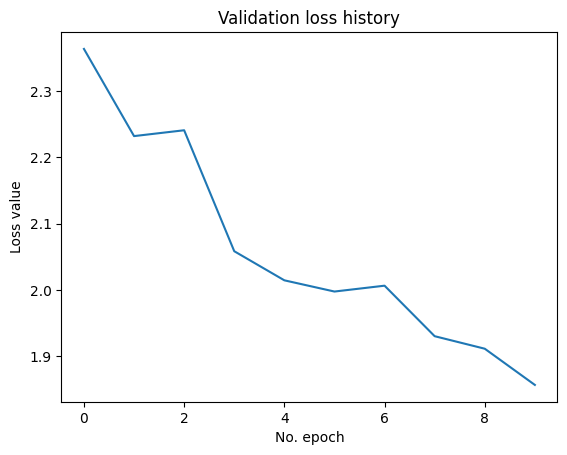

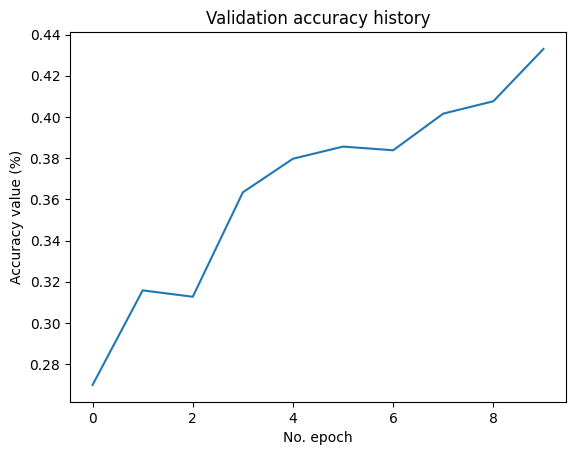

In [51]:
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()